pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/081925_qc_native/QC_with_workbench/utils.py:67: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  data_array = zscore(data_array, axis=0)
/Users/dennis.jungchildmind.org/Library/CloudStorage/OneDrive-ChildMindInstitute/layer_project/cortical_layer/jupyter-notebook/081925_qc_native/QC_with_workbench/utils.py:67: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  data_array = zscore(data_array, axis=0)


I64
/Users/dennis.jungchildmind.org/Desktop/To-be-uploaded-to-CMI-server/QC/postslurm_output/exvivo_final/output_wb_120um_distmethod0/I64/lh/inf_120um_method0_wb_raw_intensity.npz
Loaded ex-vivo subject: I64, hemisphere: lh
/Users/dennis.jungchildmind.org/Desktop/To-be-uploaded-to-CMI-server/QC/postslurm_output/exvivo_final/output_wb_120um_distmethod0/I64/rh/inf_120um_method0_wb_raw_intensity.npz
I63
/Users/dennis.jungchildmind.org/Desktop/To-be-uploaded-to-CMI-server/QC/postslurm_output/exvivo_final/output_wb_120um_distmethod0/I63/lh/inf_120um_method0_wb_raw_intensity.npz
/Users/dennis.jungchildmind.org/Desktop/To-be-uploaded-to-CMI-server/QC/postslurm_output/exvivo_final/output_wb_120um_distmethod0/I63/rh/inf_120um_method0_wb_raw_intensity.npz
Loaded ex-vivo subject: I63, hemisphere: rh
I55
/Users/dennis.jungchildmind.org/Desktop/To-be-uploaded-to-CMI-server/QC/postslurm_output/exvivo_final/output_wb_120um_distmethod0/I55/lh/inf_120um_method0_wb_raw_intensity.npz
Loaded ex-vivo subje

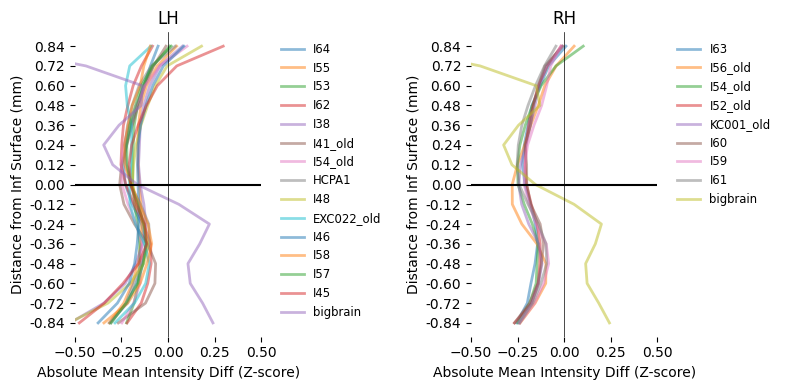

Data shape: (15, 32492)
Distance array: [ 0.84  0.72  0.6   0.48  0.36  0.24  0.12  0.   -0.12 -0.24 -0.36 -0.48
 -0.6  -0.72 -0.84]
Zero index: 7
Depths - Zero: 0.000, Up: -0.120, Down: 0.120


In [ ]:
"""
Post-processing analysis script for cortical layer intensity data.
This code processes and visualizes results from quality_control_native_surface_slurm.py

#use conda env: niwrap3912
"""
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from scipy.stats import zscore, gaussian_kde, linregress, spearmanr
from utils import *
# ============================================================================
# CONFIGURATION PARAMETERS
# ============================================================================

# Data parameters
LAYER_TYPE = 'inf' #parameters can be 'inf', 'pial', 'white'
RESOLUTION = '120um'  # 120um or 240um
DEPTH = '960um' #960 or 2000um
STEPS = 1
# Analysis parameters
data_type = "diff" #"raw" or "diff'"
do_zscore = True
do_zscore_before_diff = True
do_abs_on_diff = False
add_bigbrain = True
add_exvivo = True

# File paths
'''
base_path = "/Users/dennis.jungchildmind.org/Desktop/exvivo"
#data_base_path = f"/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/at_inf_surface/output_{DEPTH}_method0/output_{RESOLUTION}_max_{DEPTH}_dist_method0"
data_base_path = f"/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/at_{LAYER_TYPE}_surface/output_{DEPTH}_method0/output_{RESOLUTION}_max_{DEPTH}_dist_method0"
'''
atlas_path = '/Users/dennis.jungchildmind.org/Desktop/To-be-uploaded-to-CMI-server//parcellation/schaefer/Schaefer2018_400Parcels_17Networks_order.dlabel.nii'
 # Atlas setup
atlas = nib.load(atlas_path).get_fdata()[0].astype(int)
atlas_data_lh = atlas[:len(atlas)//2]
atlas_data_rh = atlas[len(atlas)//2:]
atlas_data_rh = atlas_data_rh - np.min(atlas_data_rh[atlas_data_rh != 0]) + 1
atlas_data_rh[atlas_data_rh <= 0] = 0
mask_lh = atlas_data_lh > 0
mask_rh = atlas_data_rh > 0

base_path = "/Users/dennis.jungchildmind.org/Desktop/To-be-uploaded-to-CMI-server/data/thickness_data/exvivo_final"
data_base_path= f"/Users/dennis.jungchildmind.org/Desktop/To-be-uploaded-to-CMI-server/QC/postslurm_output/exvivo_final/output_wb_{RESOLUTION}_distmethod0/"
bigbrain_base_path = '/Users/dennis.jungchildmind.org/Desktop/To-be-uploaded-to-CMI-server/data/thickness_data/BigBrain/PlosBiology2020gii/'
exvivo_bigbrain_corr_path = '../../visualization/thickness_corr_wrt_bigbrain_32k.pkl'
# Visualization parameters
xlim_max = 0.5#1.5
figure_size_depth_profiles = (8, 4)
figure_size_kde = (14, 4)
figure_size_scatter = (4, 3)

# Analysis depth positions (relative to zero index)
if RESOLUTION == '120um':
    voxel_offset_up = STEPS
    voxel_offset_down = -STEPS
else:
    voxel_offset_up =1
    voxel_offset_down = -1

# KDE parameters
kde_x_range = (-10, 10)
kde_n_points = 500

# ============================================================================
# DATA PROCESSING FUNCTIONS
# ============================================================================

# Initialize data containers
all_data = {
    'lh': {'intensity_data': [], 'subject_names': []},
    'rh': {'intensity_data': [], 'subject_names': []}
}


if add_exvivo:
    # Process ex-vivo subjects
    for subjects in os.listdir(base_path):
        if subjects:
            print(subjects)
            for hemispheres in ['lh', 'rh']:
                intensity_file_path = os.path.join(
                    data_base_path, subjects, 
                    f"{hemispheres}/{LAYER_TYPE}_{RESOLUTION}_method0_wb_raw_intensity.npz"
                )

                print(intensity_file_path)
                if os.path.exists(intensity_file_path):
                    data = np.load(intensity_file_path, allow_pickle=True)
                    dist_array = data['dist_array']
                    
                    # Process data
                    #tmp_dat = process_intensity_data(data['all_values'], data_type, do_zscore)
                    tmp_dat = process_intensity_data(data['all_values'], data_type, do_zscore, do_zscore_before_diff, do_abs_on_diff)
                    # Store data by hemisphere
                    clean_subject_name = subjects.replace('_new_confidence', '_old')
                    print(f"Loaded ex-vivo subject: {clean_subject_name}, hemisphere: {hemispheres}")
                    
                    all_data[hemispheres]['intensity_data'].append(tmp_dat)
                    all_data[hemispheres]['subject_names'].append(clean_subject_name)
                    dist_array = data['dist_array']

if add_bigbrain:
    # Load BigBrain data
    for hemi in ['lh', 'rh']:
        #specify the layer surface for the BigBrain data to match the ex vivo data
        if LAYER_TYPE == 'inf':
            #LAYER_SURFACE = 'layer3'#default, presumably mathcing the ex vivo
            LAYER_SURFACE = 'layer3'
            SUBPATH = 'at_inf_surface'
        elif LAYER_TYPE == 'pial':
            LAYER_SURFACE = 'layer0'
            SUBPATH = 'at_pial_surface'
        elif LAYER_TYPE == 'white':
            LAYER_SURFACE = 'layer6'
            SUBPATH = 'at_white_surface'
        else:
            raise ValueError(f"Invalid LAYER_TYPE: {LAYER_TYPE}")

        bb_file_path = os.path.join(bigbrain_base_path, SUBPATH, f'bigbrain_{hemi}_{LAYER_SURFACE}_{RESOLUTION}_max_{DEPTH}_method0_manual_raw_intensity.npz')
        
        if os.path.exists(bb_file_path):
            bb_data = np.load(bb_file_path)['all_values']
            #bb_data = process_intensity_data(bb_data, data_type, do_zscore)
            bb_data = process_intensity_data(bb_data, data_type, do_zscore, do_zscore_before_diff, do_abs_on_diff)
            all_data[hemi]['intensity_data'].append(bb_data)
            all_data[hemi]['subject_names'].append('bigbrain')
            print(f"Loaded BigBrain data for hemisphere: {hemi}")


        dist_array = np.load(bb_file_path)['dist_array']
# Find zero index for distance array
zero_indices = np.where(dist_array == 0)[0]
if len(zero_indices) > 0:
    zero_index = zero_indices[0]
else:
    zero_index = np.argmin(np.abs(dist_array))
    print(f"No exact zero found, using closest value at index {zero_index} with value {dist_array[zero_index]}")

# Create convenient access variables
lh_intensity_data_uncut = all_data['lh']['intensity_data']
rh_intensity_data_uncut = all_data['rh']['intensity_data']
lh_subject_names = all_data['lh']['subject_names']
rh_subject_names = all_data['rh']['subject_names']

# Print summary
print(f"\nData loading summary:")
print(f"Left hemisphere: {len(lh_subject_names)} subjects - {lh_subject_names}")
print(f"Right hemisphere: {len(rh_subject_names)} subjects - {rh_subject_names}")

# Calculate rolling average of consecutive pairs for distance array
dist_array_avg = np.array([(dist_array[i] + dist_array[i + 1]) / 2 for i in range(len(dist_array) - 1)])
print(f"Distance array average: {dist_array_avg}")

# Plot depth profiles for both hemispheres
plt.figure(figsize=figure_size_depth_profiles)

for subplot_idx, (hemi, subject_names, subject_data) in enumerate([
    ('lh', lh_subject_names, lh_intensity_data_uncut),
    ('rh', rh_subject_names, rh_intensity_data_uncut)
], 1):
    
    plt.subplot(1, 2, subplot_idx)

    # Plot each subject
    grand_average_intensity = []
    for i, tmp in enumerate(subject_data):
        mean_intensity = np.nanmean(tmp, axis=1)
        #sem_intensity = np.nanstd(tmp, axis=1) / np.sqrt(tmp.shape[1] - 1)
        std_intensity = np.nanstd(tmp, axis=1)
        yvals = []
        if data_type == 'raw':
            yvals = dist_array
        elif data_type == 'diff':
            yvals = dist_array_avg
        
        # Plot a continuous errorbar (line with shaded error region)
        plt.plot(mean_intensity, yvals, '-', linewidth=2, alpha=0.5, label=subject_names[i])
        
        if data_type != 'diff':
            plt.fill_betweenx(yvals, mean_intensity - std_intensity, mean_intensity + std_intensity, 
                            alpha=0.1, linewidth=0, label=None)
            
        grand_average_intensity.append(mean_intensity)

    # Plot grand average
    grand_average_intensity = np.nanmean(grand_average_intensity, axis=0)
    if not add_bigbrain and add_exvivo:
        plt.plot(grand_average_intensity, yvals, 'k-', linewidth=4, 
                 alpha=1, label='Grand Average', zorder=0)
    
    # Formatting
    if do_zscore:
        #plt.xlim(-xlim_max, 0.1) exvivo
        plt.xlim(-xlim_max,xlim_max)
        if do_abs_on_diff:
            plt.xlim(0.2,xlim_max+0.1) #exvivo
            #plt.xlim(0.1,xlim_max+0.2) #bigbrain

    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=1.5)
    if data_type == 'diff':
        plt.xlabel('Absolute Mean Intensity Diff (Z-score)')
    else:
        plt.xlabel('Mean Intensity (Z-score, ±std)')
    plt.ylabel('Distance from Inf Surface (mm)')
    #show every ytick label
    plt.yticks(yvals, [f'{y:.2f}' for y in yvals])
    plt.title(f'{hemi.upper()}')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', frameon=False)
    
    # Remove spines
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.show()

# Analyze intensity data at specific depth positions
print(f"Data shape: {subject_data[0].shape}")
print(f"Distance array: {dist_array_avg}")

# Find key depth positions using configured offsets
zero_index = np.where(dist_array_avg == 0)[0][0]
x_voxel_up = zero_index + voxel_offset_up
x_voxel_down = zero_index + voxel_offset_down

print(f"Zero index: {zero_index}")
print(f"Depths - Zero: {dist_array_avg[zero_index]:.3f}, Up: {dist_array_avg[x_voxel_up]:.3f}, Down: {dist_array_avg[x_voxel_down]:.3f}")


IndexError: index 14 is out of bounds for axis 0 with size 14

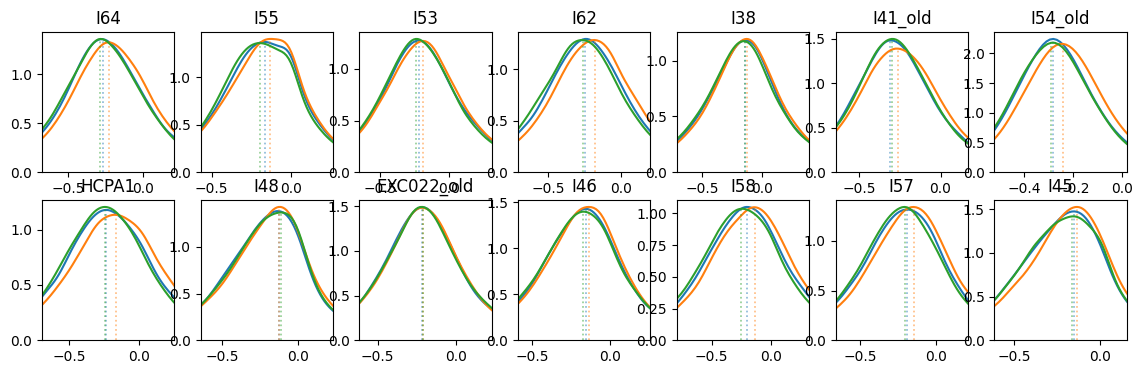

In [81]:
# Plot KDE distributions for each subject
hemi = 'lh'
subject_data = lh_intensity_data_uncut if hemi == 'lh' else rh_intensity_data_uncut
subject_names = lh_subject_names if hemi == 'lh' else rh_subject_names
n_subjects = len(subject_data)

fig, axes = plt.subplots(2, 7, figsize=figure_size_kde)
axes = axes.flatten()


# Storage for peak distances
peak_distances_all_subjects = {
    'at_surface': [],
    'x_voxel_up': [],
    'x_voxel_down': []
}

# Define positions for analysis
positions = [
    (zero_index, f'at {LAYER_TYPE} surface', 'at_surface'),
    (x_voxel_up, f'{voxel_offset_up} voxel up', 'x_voxel_up'),
    (x_voxel_down, f'{voxel_offset_down} voxel down', 'x_voxel_down')
]

for i, tmp in enumerate(subject_data):
    ax = axes[i]
    tmp = np.where(~np.isnan(tmp), tmp, 0)  # Remove NaN values
    
    for pos_idx, label, key in positions:
        tmp_kde = tmp[pos_idx, :]
        #check if there is any Nan values
        #x_range = np.linspace(kde_x_range[0], kde_x_range[1], kde_n_points)
        x_range = np.linspace(np.nanmin(tmp_kde), np.nanmax(tmp_kde), kde_n_points)
        kde = gaussian_kde(tmp_kde)
        kde_vals = kde(x_range)
        line = ax.plot(x_range, kde_vals, alpha=1, linewidth=1.5, label=label)
        
        # Add peak indicator and store peak distance
        peak_idx = np.argmax(kde_vals)
        peak_x, peak_y = x_range[peak_idx], kde_vals[peak_idx]
        ax.plot([peak_x, peak_x], [0, peak_y], ':', alpha=0.5, 
                linewidth=1.25, color=line[0].get_color())
        
        peak_distances_all_subjects[key].append(peak_x)
    
    #if do_zscore:
        #ax.set_xlim(-0.4,0.2)
      #  ax.set_xlim(-0.4,0.4)
    #else:
        #ax.set_xlim(np.nanpercentile(tmp[pos_idx, :], 20), np.nanpercentile(tmp[pos_idx, :],90)) #for inf
        ax.set_xlim(np.nanpercentile(tmp[pos_idx, :], 10), np.nanpercentile(tmp[pos_idx, :],90)) #for white

    ax.set_ylim(bottom=0)
    ax.set_title(f'{subject_names[i]}')

# Add legend
if n_subjects < len(axes):
    legend_ax = axes[n_subjects]
    legend_ax.axis('off')
    for pos_idx, label, key in positions:
        legend_ax.plot([], [], alpha=1, linewidth=1.5, label=label)
    legend_ax.legend(loc='center', frameon=False)

# Hide remaining empty subplots
for j in range(n_subjects + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


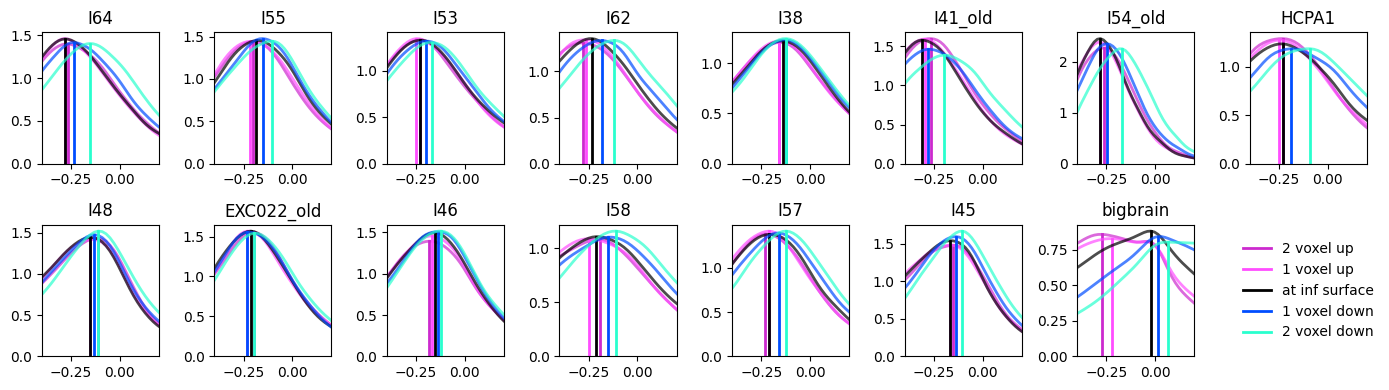

In [ ]:
#for all +/-3,2,1, and inf
# Plot KDE distributions for each subject
hemi = 'lh'
target_voxel = '1_voxel_down'


subject_data = lh_intensity_data_uncut if hemi == 'lh' else rh_intensity_data_uncut
subject_names = lh_subject_names if hemi == 'lh' else rh_subject_names
n_subjects = len(subject_data)

fig, axes = plt.subplots(2, 8, figsize=figure_size_kde)
axes = axes.flatten()


# Storage for peak distances
peak_distances_all_subjects = {
    '2_voxel_up': [],
    '1_voxel_up': [],
    'at_surface': [],
    '1_voxel_down': [],
    '2_voxel_down': [],
    '3_voxel_down': [],
    '4_voxel_down': [],
}

# Define positions for analysis
#before this it was flipped.. 100725 DJ
#zero_index-2 should be going up because the data direction is from pial surface to white surface
positions = [
    (zero_index-2, f'{2} voxel up', '2_voxel_up'),
    (zero_index-1, f'{1} voxel up', '1_voxel_up'),
    (zero_index, f'at {LAYER_TYPE} surface', 'at_surface'),
    (zero_index+1, f'{1} voxel down', '1_voxel_down'),
    (zero_index+2, f'{2} voxel down', '2_voxel_down'),

]
zero_index_at = 0;
# Create gradient colors for each position
n_positions = len(positions)
colors = plt.cm.jet(np.linspace(0, 1, 6))
# Make the at_surface color black
colors[zero_index_at] = [0, 0, 0, 1]  # Red color for at_surface position
#
colors = [
    [0.8,0.16129032,0.80645161,1],
    [1,0.3,1,1],
    [0, 0, 0, 1],
    [0.0, 0.3, 1.0, 1.0],
    [0.16129032, 1.0, 0.80645161, 1.0],

]
for i, tmp in enumerate(subject_data):
    ax = axes[i]
    tmp = np.where(~np.isnan(tmp), tmp, 0)  # Remove NaN values

    min_val = int(np.nanmin(tmp))
    max_val = int(np.nanmax(tmp))
    if hemi == 'lh':
        mask = mask_lh
    else:
        mask = mask_rh
    for j, (pos_idx, label, key) in enumerate(positions):

        if tmp.shape[1] != mask.shape[0]:
            tmp_kde = tmp[pos_idx,:]# this is because of bigbrain. just skip masking on bigbrain
        else:   
            tmp_kde = tmp[pos_idx, mask]
        #check if there is any Nan values
        #x_range = np.linspace(kde_x_range[0], kde_x_range[1], kde_n_points)
        x_range = np.linspace(min_val, max_val, kde_n_points)
        kde = gaussian_kde(tmp_kde)
        kde_vals = kde(x_range)
        line = ax.plot(x_range, kde_vals, alpha=0.7, linewidth=2, label=label, color=colors[j])
        # Add peak indicator and store peak distance
        peak_idx = np.argmax(kde_vals)
        peak_x, peak_y = x_range[peak_idx], kde_vals[peak_idx]

        if  j== zero_index_at:
            ax.plot([peak_x, peak_x], [0, peak_y], '-', alpha=1, 
                    linewidth=2, color=colors[j])
        else:
            ax.plot([peak_x, peak_x], [0, peak_y], '-', alpha=1, 
                    linewidth=2, color=colors[j])
        
        #isn't peak_x median?
        peak_x = np.median(tmp_kde)
        peak_distances_all_subjects[key].append(peak_x)
    
    if do_zscore:
        ax.set_xlim(-0.4,0.2)
        #ax.set_xlim(-1.5,1.5)
    ax.set_ylim(bottom=0)
    ax.set_title(f'{subject_names[i]}')

# Add legend
if n_subjects < len(axes):
    legend_ax = axes[n_subjects]
    legend_ax.axis('off')
    for j, (pos_idx, label, key) in enumerate(positions):
        legend_ax.plot([], [], alpha=1, linewidth=2, label=label, color=colors[j])
    legend_ax.legend(loc='center', frameon=False)

# Hide remaining empty subplots
for j in range(n_subjects + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()



In [ ]:
with open(exvivo_bigbrain_corr_path, 'rb') as f:
    data = pickle.load(f)
    subject_names_corr = data['subject_names']
    print(len(subject_names_corr['lh']))
    print(len(subject_names_corr['rh']))
    corr_data = data['thickness_corr_wrt_bigbrain']
    print(corr_data['lh']['supra'].shape)
    #find index of subject_names_corr in subject_names['lh'] where macaque is included
    lh_index = [i for i, subject in enumerate(subject_names_corr['lh']) if 'macaque' in subject]
    rh_index = [i for i, subject in enumerate(subject_names_corr['rh']) if 'macaque' in subject]
    #remove these subjects from corr_data
    corr_data['lh']['supra'] = np.delete(corr_data['lh']['supra'], lh_index, axis=0)
    corr_data['lh']['infra'] = np.delete(corr_data['lh']['infra'], lh_index, axis=0)

    #remove these subjects from subject_names_corr
    subject_names_corr['lh'] = np.delete(subject_names_corr['lh'], lh_index, axis=0)
    print(len(subject_names_corr['lh']))
    #remove these subjects from rh_subject_names
    subject_names_corr['rh'] = np.delete(subject_names_corr['rh'], rh_index, axis=0)
    print(len(subject_names_corr['rh']))
    print(corr_data['lh']['supra'].shape)
    print(corr_data['lh']['infra'].shape)


17
9
(17,)
15
9
(15,)
(15,)


[15, 16]
[]
-0.09338501544114597 0.7508399239456887
0.3286013551212151 0.25134158797409883


Text(0, 0.5, 'Spatial similarity between BigBrain and ex vivo')

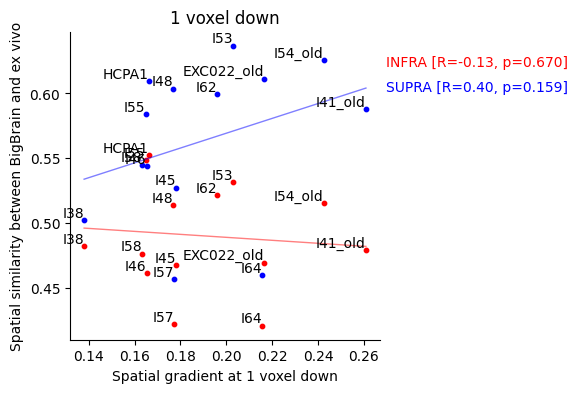

In [ ]:


'''
with open('/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/layer_project/cortical_layer/jupyter-notebook/visualization/thickness_corr_wrt_bigbrain.pkl', 'rb') as f:
    data = pickle.load(f)
    subject_names_corr = data['subject_names']
    thickness_corr_wrt_bigbrain = data['thickness_corr_wrt_bigbrain']

'''
#with open('/Users/dennis.jungchildmind.org/OneDrive - Child Mind Institute/layer_project/cortical_layer/jupyter-notebook/081925_qc_native/thickness_corr_wrt_bigbrain.pkl', 'rb') as f:
with open(exvivo_bigbrain_corr_path, 'rb') as f:
    data = pickle.load(f)
    subject_names_corr = data['subject_names']
    thickness_wrt_bigbrain = data['thickness_corr_wrt_bigbrain']
    lh_index = [i for i, subject in enumerate(subject_names_corr['lh']) if 'macaque' in subject]
    rh_index = [i for i, subject in enumerate(subject_names_corr['rh']) if 'macaque' in subject]
    print(lh_index)
    print(rh_index)

    thickness_wrt_bigbrain['lh']['supra'] = np.delete(thickness_wrt_bigbrain['lh']['supra'], lh_index, axis=0)
    thickness_wrt_bigbrain['lh']['infra'] = np.delete(thickness_wrt_bigbrain['lh']['infra'], lh_index, axis=0)
    subject_names_corr['lh'] = np.delete(subject_names_corr['lh'], lh_index, axis=0)
    thickness_wrt_bigbrain['rh']['supra'] = np.delete(thickness_wrt_bigbrain['rh']['supra'], rh_index, axis=0)
    thickness_wrt_bigbrain['rh']['infra'] = np.delete(thickness_wrt_bigbrain['rh']['infra'], rh_index, axis=0)
    subject_names_corr['rh'] = np.delete(subject_names_corr['rh'], rh_index, axis=0)
    '''
    #remove subject names that include macaque
    subject_names_corr['lh'] = [subject for subject in subject_names_corr['lh'] if 'macaque' not in subject]
    subject_names_corr['rh'] = [subject for subject in subject_names_corr['rh'] if 'macaque' not in subject]
    thickness_wrt_bigbrain = data['thickness_corr_wrt_bigbrain']
    #do the same for thickness wrt bigbrain

    #ylabel_name = 'MI'#or "Rho"(Correlation with BigBrain')
    ylabel_name = "Spatial similarity between BigBrain and ex vivo"
    #need to reorder this data with the lh_subject_names and rh_subject_names
    #rh_index = [rh_subject_names.index(subject) for subject in subject_names_corr['rh']]
    lh_index = [lh_subject_names.index(subject) for subject in subject_names_corr['lh']]
    #thickness_wrt_bigbrain['rh']['supra'] = [thickness_wrt_bigbrain['rh']['supra'][i] for i in rh_index]
    thickness_wrt_bigbrain['lh']['supra'] = [thickness_wrt_bigbrain['lh']['supra'][i] for i in lh_index]
    #thickness_wrt_bigbrain['rh']['infra'] = [thickness_wrt_bigbrain['rh']['infra'][i] for i in rh_index]
    thickness_wrt_bigbrain['lh']['infra'] = [thickness_wrt_bigbrain['lh']['infra'][i] for i in lh_index]
    '''




grad_diff = np.abs(np.array(peak_distances_all_subjects[target_voxel]))
plt.figure(figsize=(4,4))


#color by layer type
colors = ['r','b']
for k,layer_type in enumerate(['infra','supra']):
    thickness_wrt_bigbrain_wo_bigbrain = np.array(thickness_wrt_bigbrain[hemi][layer_type][:-1])
    plt.scatter(grad_diff[:-1], thickness_wrt_bigbrain_wo_bigbrain, s=10, marker='o', c=colors[k])
    for i in range(len(grad_diff[:-1])):
        plt.text(grad_diff[i], thickness_wrt_bigbrain_wo_bigbrain[i], subject_names[i], fontsize=10, ha='right', va='bottom')
    #do linear regression
    slope, intercept, r_value, p_value, std_err = linregress(grad_diff[:-1], thickness_wrt_bigbrain_wo_bigbrain)
    print(r_value, p_value)

    sp_rho, sp_p_value = spearmanr(grad_diff[:-1], thickness_wrt_bigbrain_wo_bigbrain)
    x_vals = np.linspace(np.min(grad_diff[:-1]), np.max(grad_diff[:-1]), 100)
    plt.plot(x_vals, slope * x_vals + intercept, color=colors[k], linestyle='-', linewidth=1, alpha=0.5)
    # Place the annotation outside the plot box, e.g., to the right of the axes
    plt.gca().annotate(
        f'{layer_type.upper()} [R={sp_rho:.2f}, p={sp_p_value:.3f}]',
        xy=(1.02, 0.9 - k*0.08), xycoords='axes fraction',
        ha='left', va='center', fontsize=10, color=colors[k]
    )
plt.title(target_voxel.replace('_', ' '))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

if data_type == 'diff':
    #plt.xlabel('Difference between peak of \n at surface and 1 voxel down')
    plt.xlabel(f'Spatial gradient at {target_voxel.replace("_", " ")}')
elif data_type == 'raw':
    #plt.xlabel('Difference between peak of \n 1/2 voxel up and 1/2 voxel down')
    plt.xlabel(f'Raw at {target_voxel}')
plt.ylabel(ylabel_name)



In [ ]:
print(subject_names_corr)
print(thickness_wrt_bigbrain)
print(len(lh_subject_names))
print(thickness_wrt_bigbrain['lh']['supra'].shape)
print(len(subject_names_corr['lh']))
print(subject_names_corr['lh'])

{'lh': ['EXC022_old', 'I41_old', 'I54_old', 'HCPA1', 'I38', 'I45', 'I46', 'I48', 'I53', 'I55', 'I57', 'I58', 'I62', 'I64', 'bigbrain', 'macaque(H)', 'macaque'], 'rh': ['KC001_old', 'I52_old', 'I54_old', 'I56_old', 'I59', 'I60', 'I61', 'I63', 'bigbrain']}
{'lh': {'supra': array([0.45967417, 0.58404503, 0.63684968, 0.59927534, 0.50198256,
       0.58796654, 0.62568614, 0.60924577, 0.603623  , 0.61145235,
       0.54361015, 0.54509005, 0.45645962, 0.52720577, 0.47284742,
       0.63762033, 1.        ]), 'infra': array([0.42062811, 0.54835727, 0.53132838, 0.52130495, 0.48226999,
       0.47874324, 0.51512829, 0.55216882, 0.51387362, 0.46933315,
       0.46117124, 0.47636482, 0.42178   , 0.46754052, 0.45071183,
       0.71682726, 1.        ])}, 'rh': {'supra': array([0.55285004, 0.59330335, 0.65334793, 0.58600216, 0.68864727,
       0.7058677 , 0.66468462, 0.61779917, 1.        ]), 'infra': array([0.49860053, 0.58419035, 0.63424536, 0.55672193, 0.60589393,
       0.64834057, 0.62594976, 0.5